In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
from experiment_tools import generate_correct_model, generate_wrong_model,experiment

## Run model wrong experiment

In [3]:
X_test,y_test, _ = generate_wrong_model(10000, pmax = 50)
number_run = 30

all_risk = []
for _ in tqdm(range(number_run)):
    X,y, beta = generate_wrong_model(400, pmax = 50)
    all_risk.append(experiment(X, y,X_test,y_test, step_size=1, k_max=16, pmax=50, sigma2=1/40))
all_risk = np.stack(all_risk)
average_over_run_square_risks = np.mean(all_risk,axis=2)
number_of_samples_used = np.arange(2,len(X)+1)

100%|██████████| 30/30 [07:23<00:00, 14.79s/it]


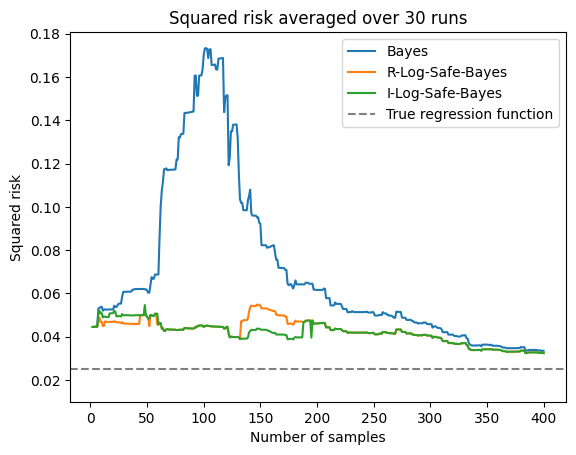

In [4]:
plt.figure()
plt.plot(number_of_samples_used,all_risk[0],label = ["Bayes","R-Log-Safe-Bayes","I-Log-Safe-Bayes"])
plt.xlabel("Number of samples")
plt.ylabel("Squared risk")
plt.axhline(y=(1/40), linestyle='--',color = "gray",label = "True regression function")
plt.ylim(bottom =0.01)
plt.legend()
plt.title(f"Squared risk averaged over {number_run} runs")
plt.title
plt.show()

## Run correct model experiment

In [5]:
X_test,y_test, _ = generate_correct_model(10000, pmax = 50)
number_run = 30

all_risk = []
for _ in tqdm(range(number_run)):
    X,y, beta = generate_correct_model(400, pmax = 50)
    all_risk.append(experiment(X, y,X_test,y_test, step_size=1, k_max=16, pmax=50, sigma2=1/40))
all_risk = np.stack(all_risk)
average_over_run_square_risks = np.mean(all_risk,axis=2)
number_of_samples_used = np.arange(2,len(X)+1)

100%|██████████| 30/30 [08:28<00:00, 16.95s/it]


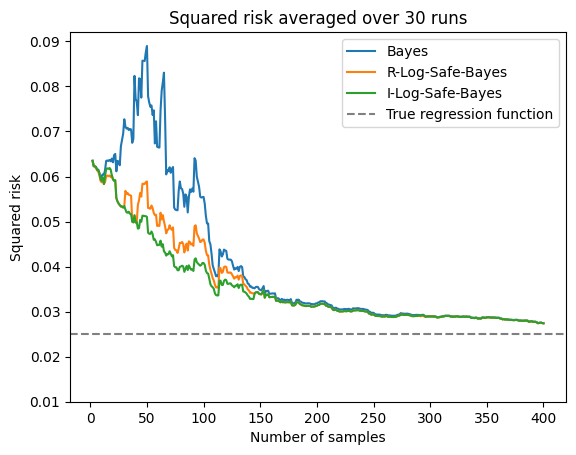

In [6]:
plt.figure()
plt.plot(number_of_samples_used,all_risk[0],label = ["Bayes","R-Log-Safe-Bayes","I-Log-Safe-Bayes"])
plt.xlabel("Number of samples")
plt.ylabel("Squared risk")
plt.axhline(y=(1/40), linestyle='--',color = "gray",label = "True regression function")
plt.ylim(bottom =0.01)
plt.legend()
plt.title(f"Squared risk averaged over {number_run} runs")
plt.title
plt.show()